In [64]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [65]:
# Define the universe of discourses for input and outputs
error_range = np.arange(-10, 10.1, 0.1)
error_dot_range = np.arange(-10, 10.1, 0.1)
Kp_range = np.arange(0, 10.1, 0.1)
Ki_range = np.arange(0, 10.1, 0.1)
Kd_range = np.arange(0, 10.1, 0.1)

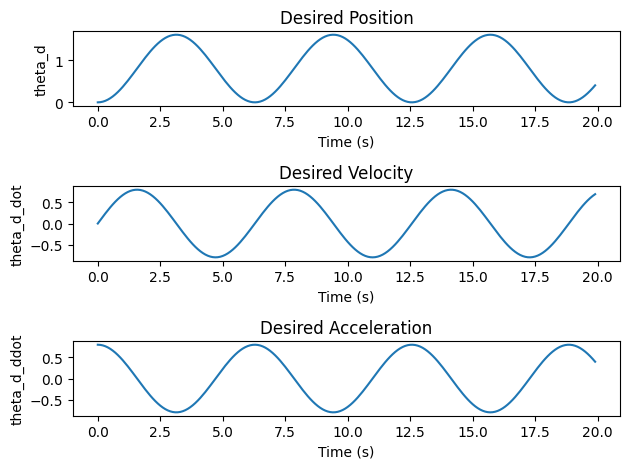

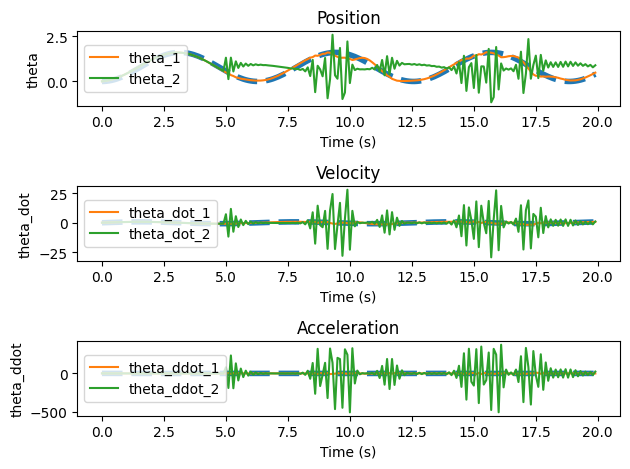

In [66]:
# Parameters
l_1 = 0.39
l_2 = 0.156
r_1 = 0.195
r_2 = 0.078
m_1 = 3.3
m_2 = 0.3
i_z1 = 0.1255  # m_1 * r_1^2
i_z2 = 0.00183  # m_2 * r_2^2

alpha = i_z1 + i_z2 + m_1 * r_1**2 + m_2 * (l_1**2 + r_2**2)
beta = m_2 * l_1 * r_2
delta = i_z2 + m_2 * r_2**2

dt = 0.1
time = np.arange(0, 20, dt)

# Desired trajectory
theta_d = np.zeros(len(time))
theta_d_dot = np.zeros(len(time))
theta_d_ddot = np.zeros(len(time))

# Initial conditions
theta_d[0] = 0.8 - 0.8 * np.cos(time[0])
theta_d_dot[0] = 0.8 * np.sin(time[0])
theta_d_ddot[0] = 0.8 * np.cos(time[0])

# Define the ODE function
def dydt(t, y):
    return np.array([y[1], y[2], -0.8 * np.sin(t)]) # dot, ddot, dddot

# RK4 integration
for i in range(len(time) - 1):
    t = time[i]
    y = np.array([theta_d[i], theta_d_dot[i], theta_d_ddot[i]])

    k1 = dydt(t, y)
    k2 = dydt(t + dt / 2, y + dt / 2 * k1)
    k3 = dydt(t + dt / 2, y + dt / 2 * k2)
    k4 = dydt(t + dt, y + dt * k3)

    y_next = y + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)

    theta_d[i + 1] = y_next[0]
    theta_d_dot[i + 1] = y_next[1]
    theta_d_ddot[i + 1] = y_next[2]

# Plot results
plt.figure()
plt.subplot(3, 1, 1)
plt.plot(time, theta_d)
plt.xlabel('Time (s)')
plt.ylabel('theta_d')
plt.title('Desired Position')

plt.subplot(3, 1, 2)
plt.plot(time, theta_d_dot)
plt.xlabel('Time (s)')
plt.ylabel('theta_d_dot')
plt.title('Desired Velocity')

plt.subplot(3, 1, 3)
plt.plot(time, theta_d_ddot)
plt.xlabel('Time (s)')
plt.ylabel('theta_d_ddot')
plt.title('Desired Acceleration')

plt.tight_layout()
plt.show()



# Define the unit step function
def unit_step(t):
    return 1 if t >= 0 else 0

def torque_with_force_2(theta, theta_dot, theta_des, theta_dot_des, theta_ddot_des, force_2, _theta, t):
    c2 = np.cos(theta[1])
    s2 = np.sin(theta[1])

    Kp = 16
    Kd = 4

    Ki = 16

    error = theta_des - theta
    error_dot = theta_dot_des - theta_dot
    global integral_error
    integral_error += error*dt

    C = c_matrix(theta, theta_dot)
    M = m_matrix(theta)

    feedback = np.dot(Kd * np.eye(2), error_dot) + np.dot(Kp * np.eye(2), error) + np.dot(np.eye(2) * Ki, integral_error)
    tau = (
        M @ (theta_ddot_des + feedback)
        + C @ theta_dot
        + np.array([2 * force_2 * r_2 + force_2 * l_1 * c2, 
                    2 * force_2 * r_2 + force_2 * l_1 * c2 - force_2 * l_1 * s2 * (theta - _theta).sum()])
    )  # G = 0

    return tau

# Define the C matrix
def c_matrix(theta, theta_dot):
    s2 = np.sin(theta[1])
    c11 = -beta * s2 * theta_dot[1]
    c12 = -beta * s2 * (theta_dot[0] + theta_dot[1])
    c21 = beta * s2 * theta_dot[0]
    c22 = 0

    return np.array([[c11, c12], [c21, c22]])

# Define the M matrix
def m_matrix(theta):
    c2 = np.cos(theta[1])
    m11 = alpha + 2 * beta * c2
    m12 = delta + beta * c2
    m21 = delta + beta * c2
    m22 = delta

    return np.array([[m11, m12], [m21, m22]])

# Simulation initial conditions
_theta = np.array([0.0, 0.0])
theta = np.array([0.0, 0.0])
theta_dot = np.array([0.0, 0.0])
integral_error = np.zeros(2)

# Initialize arrays to store results
theta_history = []
theta_dot_history = []
theta_ddot_history = []
tau_history = []
M_history = []
C_history = []

# Simulation loop
for t in range(len(time)):
    theta_des = np.array([theta_d[t], theta_d[t]])
    theta_dot_des = np.array([theta_d_dot[t], theta_d_dot[t]])
    theta_ddot_des = np.array([theta_d_ddot[t], theta_d_ddot[t]])

    force_2 = 1.2 * unit_step(time[t] - 5)

    tau = torque_with_force_2(theta, theta_dot, theta_des, theta_dot_des, theta_ddot_des, force_2, _theta, t)

    C = c_matrix(theta, theta_dot)
    M = m_matrix(theta)

    # 동역학 모델을 사용하여 상태 업데이트
    theta_ddot = np.linalg.inv(M) @ (tau - C @ theta_dot)  # G = 0

    theta_dot += theta_ddot * dt
    theta += theta_dot * dt

    # 결과 출력
    # print(f"Time: {time[t]:.2f}, Theta: {theta}, Theta_dot: {theta_dot}, Tau: {tau}")

    theta_history.append(np.copy(theta))
    theta_dot_history.append(np.copy(theta_dot))
    theta_ddot_history.append(np.copy(theta_ddot))
    tau_history.append(np.copy(tau))

    M_history.append(np.copy(M))
    C_history.append(np.copy(C))

# Convert results to arrays for plotting
theta_history = np.array(theta_history)
theta_dot_history = np.array(theta_dot_history)
theta_ddot_history = np.array(theta_ddot_history)
tau_history = np.array(tau_history)

# Plot results
plt.figure()
plt.subplot(3, 1, 1)
plt.plot(time, theta_d, '--', linewidth=4)
plt.plot(time, theta_history[:, 0], label='theta_1')
plt.plot(time, theta_history[:, 1], label='theta_2')
plt.xlabel('Time (s)')
plt.ylabel('theta')
plt.title('Position')
plt.legend(loc='center left')

plt.subplot(3, 1, 2)
plt.plot(time, theta_d_dot, '--', linewidth=4)
plt.plot(time, theta_dot_history[:, 0], label='theta_dot_1')
plt.plot(time, theta_dot_history[:, 1], label='theta_dot_2')
plt.xlabel('Time (s)')
plt.ylabel('theta_dot')
plt.title('Velocity')
plt.legend(loc='center left')

plt.subplot(3, 1, 3)
plt.plot(time, theta_d_ddot, '--', linewidth=4)
plt.plot(time, theta_ddot_history[:, 0], label='theta_ddot_1')
plt.plot(time, theta_ddot_history[:, 1], label='theta_ddot_2')
plt.xlabel('Time (s)')
plt.ylabel('theta_ddot')
plt.title('Acceleration')
plt.legend(loc='center left')

plt.tight_layout()
plt.show()

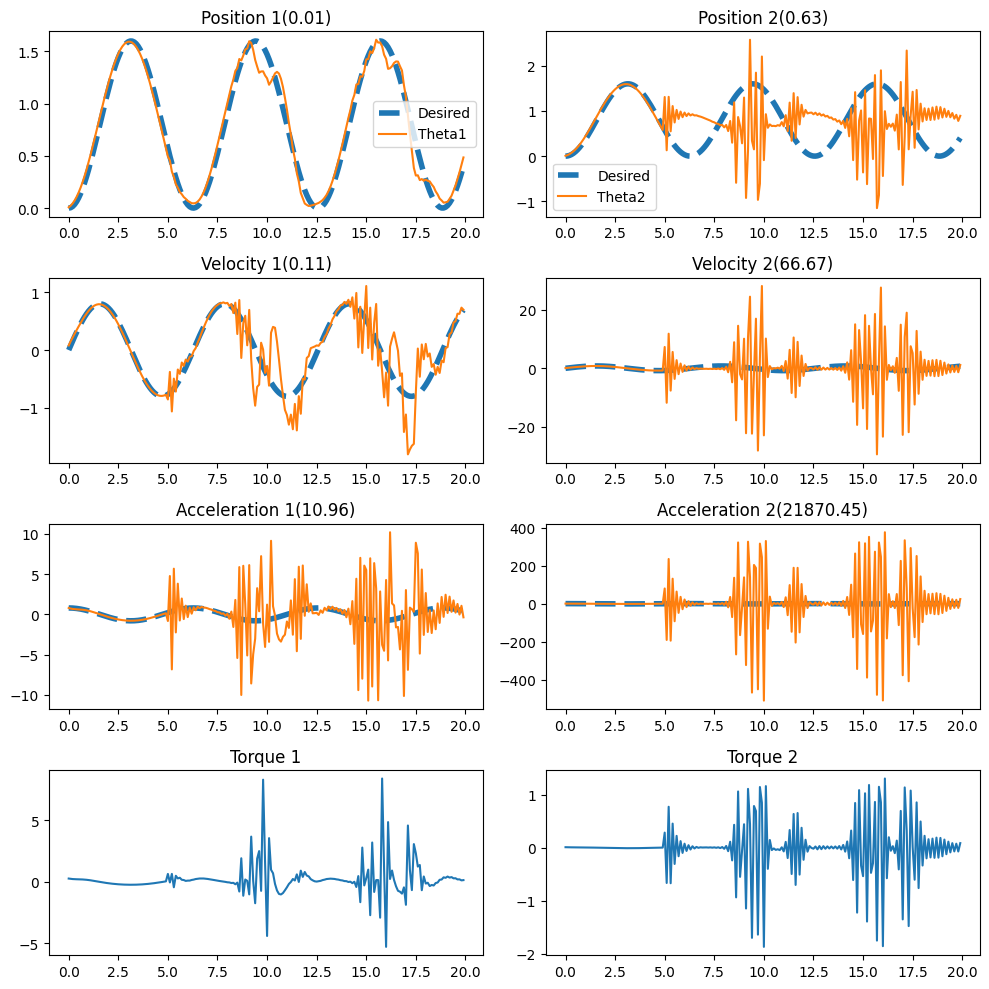

In [67]:

theta_history = np.array(theta_history)
theta_dot_history = np.array(theta_dot_history)
theta_ddot_history = np.array(theta_ddot_history)
tau_history = np.array(tau_history)

plt.figure(figsize=(10, 10))
plt.subplot(4, 2, 1)
plt.plot(time, theta_d, '--', linewidth=4)
plt.plot(time, theta_history[:, 0])
plt.legend(["Desired", "Theta1"])
plt.title(f"Position 1({mean_squared_error(theta_d, theta_history[:, 0]):.2f})")

plt.subplot(4, 2, 2)
plt.plot(time, theta_d, '--', linewidth=4)
plt.plot(time, theta_history[:, 1])
plt.legend(["Desired", "Theta2"])
plt.title(f"Position 2({mean_squared_error(theta_d, theta_history[:, 1]):.2f})")

plt.subplot(4, 2, 3)
plt.plot(time, theta_d_dot, '--', linewidth=4)
plt.plot(time, theta_dot_history[:, 0])
plt.title(f"Velocity 1({mean_squared_error(theta_d_dot, theta_dot_history[:, 0]):.2f})")

plt.subplot(4, 2, 4)
plt.plot(time, theta_d_dot, '--', linewidth=4)
plt.plot(time, theta_dot_history[:, 1])
plt.title(f"Velocity 2({mean_squared_error(theta_d_dot, theta_dot_history[:, 1]):.2f})")

plt.subplot(4, 2, 5)
plt.plot(time, theta_d_ddot, '--', linewidth=4)
plt.plot(time, theta_ddot_history[:, 0])
plt.title(f"Acceleration 1({mean_squared_error(theta_d_ddot, theta_ddot_history[:, 0]):.2f})")

plt.subplot(4, 2, 6)
plt.plot(time, theta_d_ddot, '--', linewidth=4)
plt.plot(time, theta_ddot_history[:, 1])
plt.title(f"Acceleration 2({mean_squared_error(theta_d_ddot, theta_ddot_history[:, 1]):.2f})")

plt.subplot(4, 2, 7)
plt.plot(time, tau_history[:, 0])
plt.title(f"Torque 1")

plt.subplot(4, 2, 8)
plt.plot(time, tau_history[:, 1])
plt.title(f"Torque 2")

plt.tight_layout()
plt.show()


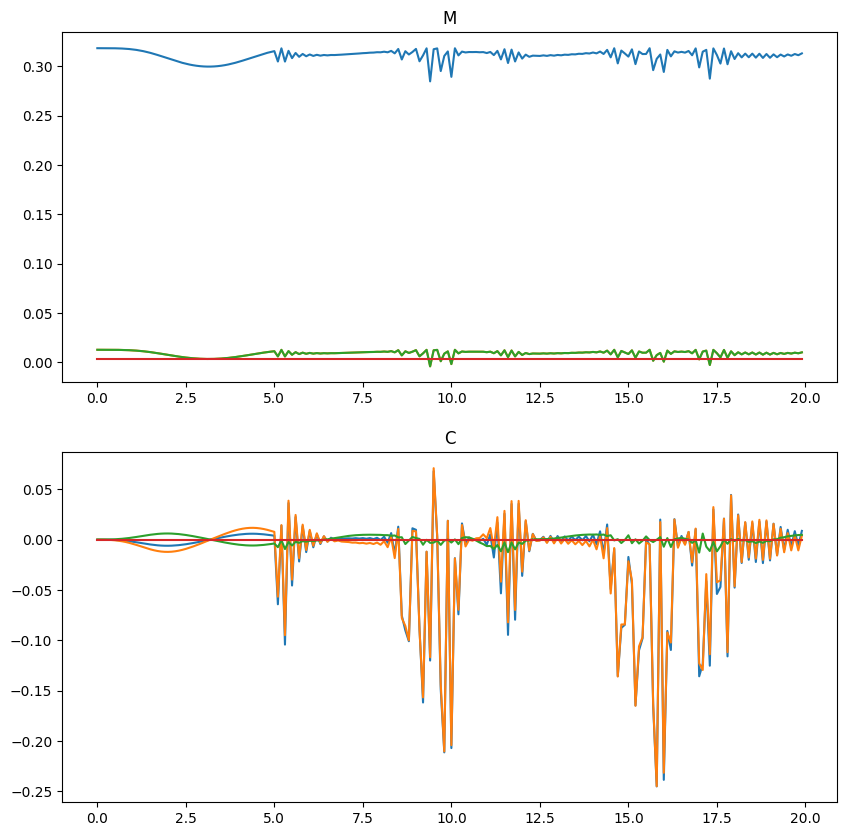

In [68]:
_M_history = np.array(M_history)
_C_history = np.array(C_history)

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(time, _M_history[:, 0, 0])
plt.plot(time, _M_history[:, 0, 1])
plt.plot(time, _M_history[:, 1, 0])
plt.plot(time, _M_history[:, 1, 1])
plt.title(f"M")

plt.subplot(2, 1, 2)
plt.plot(time, _C_history[:, 0, 0])
plt.plot(time, _C_history[:, 0, 1])
plt.plot(time, _C_history[:, 1, 0])
plt.plot(time, _C_history[:, 1, 1])
plt.title(f"C")
plt.show()


In [69]:
import numpy as np

# Convert theta_history to a numpy array
theta_history = np.array(theta_history)

# Save theta_history as a text file
np.savetxt('theta_history.txt', theta_history)

In [70]:
import pandas as pd

df = pd.read_csv('theta_history.txt', sep=' ', header=None)

In [71]:
df

,0,1
0,0.008000,0.008000
1,0.023250,0.023250
2,0.045249,0.045249
3,0.073691,0.073691
4,0.108398,0.108398
...,...,...
195,0.216296,0.953503
196,0.279199,0.828636
197,0.341889,0.914183
198,0.415277,0.779022


In [72]:
first_column = df.iloc[:, 0]
np.array(first_column)

array([0.008     , 0.02325012, 0.04524869, 0.07369111, 0.10839823,
       0.14924123, 0.1960753 , 0.248689  , 0.3067721 , 0.36990125,
       0.43754062, 0.50905345, 0.58372048, 0.66076148, 0.73935687,
       0.81866753, 0.89785164, 0.97607827, 1.05253784, 1.12645013,
       1.19707034, 1.26369408, 1.32566163, 1.38236208, 1.43323742,
       1.47778676, 1.51557054, 1.5462147 , 1.56941451, 1.58493805,
       1.59262892, 1.59240838, 1.58427652, 1.56831259, 1.54467443,
       1.51359694, 1.47538984, 1.43043443, 1.37917977, 1.32213803,
       1.25987936, 1.19302603, 1.12224622, 1.0482473 , 0.97176873,
       0.89357467, 0.81444637, 0.7351744 , 0.6565507 , 0.57936077,
       0.49396628, 0.45623302, 0.35012225, 0.30080534, 0.22907218,
       0.19549315, 0.15433674, 0.13287145, 0.10558059, 0.08911046,
       0.06923242, 0.05779571, 0.0472307 , 0.0455111 , 0.04889758,
       0.06180199, 0.08244768, 0.11245449, 0.15085531, 0.19752231,
       0.25173057, 0.3125025 , 0.37919717, 0.45051944, 0.52596